In [1]:
import numpy as np
import pagn.constants as ct
import matplotlib.pyplot as plt
import pagn
import argparse

import NT_disk_Eqns_V1 as jscript
import binary_formation_distribution_V8 as myscript
import binary_formation_distribution_V10 as myscript2

from scipy.interpolate import UnivariateSpline

from os import makedirs

import pandas as pd

import Novikov
import Thompson_edited as edit
from scipy.interpolate import interp1d
from pagn.opacities import electron_scattering_opacity
#some nicer code based on Test_zone.ipynb

In [385]:
mass_sec=np.genfromtxt("BHs_single_Zsun_rapid_nospin.dat",usecols=(0),skip_header=3,unpack=True)

winds=True

MBH_power=7

MBH_digit=1

Mbh=MBH_digit * 10**MBH_power * ct.MSun

Mmean=10 * ct.MSun 

alpha=0.1
eps=0.1
spin=0.9
le=0.1

Ledd=jscript.Ledd(Mbh, X=0.7)
Mdot_edd = Ledd / (eps*ct.c ** 2)
Mdot = le * Mdot_edd

mdot=Mdot/Mdot_edd

print(mdot)

TT='G23'
DT='SG'

if DT=="SG":
    disk = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

if DT=="NT":
    disk = Novikov.NovikovThorneAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps, spin=spin)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

R_G=Mbh * ct.G /(ct.c*ct.c)

Rsch = 2 * ct.G * Mbh / ct.c**2
Rs = disk.R / Rsch


0.1
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+07 MSun
Mdot = 2.596689e-02 MSun/yr
le = 0.1
Rs = 9.570121e-07 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+00 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5335 (R=1.25e+04 Rs)
Beginning star formation at index 5335
Mdisk = 4153970.6766642476 Msun
Mdisk/Mbh = 0.41539706766642476


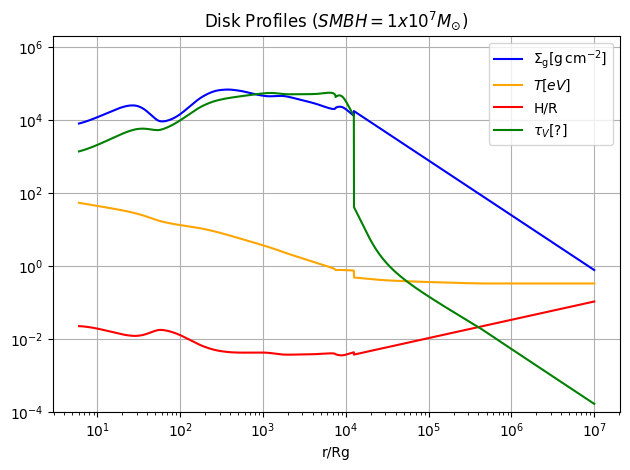

In [386]:
colour='plasma'
cmap = plt.colormaps[colour]


plt.plot(disk.R/(2*R_G), 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$', color='b')
plt.plot(disk.R/(2*R_G), disk.T*jscript.K_to_eV, label = r"$T [eV] $", color='orange')
plt.plot(disk.R/(2*R_G), disk.h/disk.R, label = r"H/R", color='r')
plt.plot(disk.R/(2*R_G), disk.tauV, label = r'$\tau_V [?]$', color='g')
plt.xlabel("r/Rg")

plt.ylim(1e-4, 2e6)
plt.xscale('log')
plt.yscale('log')
# plt.axvline(x=disk.R_AGN/(2*R_G), linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

plt.title(f'Disk Profiles ($SMBH = {MBH_digit}x10^{MBH_power}$'r'${M_{\odot}})$')
plt.legend()

plt.grid()
plt.tight_layout()
# plt.savefig(f'Torques/{DT}/Wind/SG_profiles_MBH{MBH_digit}e{MBH_power}_alpha{alpha}.pdf')
plt.show()

In [387]:
def gamma_wind(m, disk, gamma):
    ##from Zhen Pan, Huan Yang (2021), eq. 36
    ##initially developed by Kocsis, Yunes, Loeb (2011)

    ledd=jscript.Ledd(m, 0.7)

    Mbh=disk.Mbh
    Mdot=disk.Mdot

    m_edd=ledd/(ct.c**2)

    h_ratio = disk.h / disk.R
    sigma = 2*disk.h*disk.rho
    delta_v_phi = (3. - gamma) / 2. * h_ratio * disk.cs #eq.39a
    # delta_v_phi=disk.Omega*disk.R - np.sqrt(Mbh/) to code
    delta_v_dr = 1.5 * (m / (3. * Mbh))**(1./ 3.) * h_ratio**(-1.) * disk.cs #eq. 39c

    R_G=Mbh * ct.G /(ct.c*ct.c)

    vgas=-disk.Mdot/(2 * np.pi * disk.R * sigma)
    vstar=-1.3e-6 * (m/(10*ct.MSun))/(Mbh/(1e5*ct.MSun)) * (disk.R/10*R_G)**(-3)

    delta_v_r=np.abs(vgas-vstar)

    vrel2 = (delta_v_phi + delta_v_dr)**2 + delta_v_r**2 

    R_Hill = disk.R * (m / (3. * disk.Mbh))**(1./3.)
    R_BHL = ct.G * m / (vrel2 + disk.cs**2) #Bondi radius

    r_rel=np.minimum(R_BHL, R_Hill)

    Rd_gap= 0.21 * (m/Mbh)**(1/2) * (disk.h/disk.R)**(-3/4) * alpha**(-1/4) * disk.R

    rho=[]

    for i in range(0, len(r_rel)):
        if r_rel[i]>Rd_gap[i]:
            rho.append(disk.rho[i])
        elif r_rel[i]<Rd_gap[i]:
            print(1/(1+ (0.04 * (m/Mbh)**2 * (disk.h[i]/disk.R[i])**(-5) * alpha**(-1))))
            rho_d_gap= disk.rho[i] * 1/(1+ (0.04 * (m/Mbh)**2 * (disk.h[i]/disk.R[i])**(-5) * alpha**(-1)))
            rho.append(rho_d_gap)

    rho=np.array(rho)

    mdot_BHL =  (ct.G)**2 * 4.0 * np.pi * rho * m**2. / (vrel2 + disk.cs**2.)**1.5  #Bondi accretion rate, eq.37

    Mdot_flux = Mdot * np.abs(1-vstar/vgas)
    # for i in range(0, len(mdot_BHL)):
        # print(1, disk.h[i]/R_BHL[i], R_Hill[i]/R_BHL[i],  Mdot_flux[i]/mdot_BHL[i])
        # if Mdot_flux[i]<mdot_BHL[i]:
        #     print(f'Quenched by limited gas supply at {disk.R[i]/R_G} Rg')

    print(Mdot_flux/mdot_BHL)

    mdot_wind = np.minimum(mdot_BHL * np.minimum(1., np.minimum(disk.h/R_BHL, R_Hill/R_BHL)), Mdot_flux)

    dot_J = - disk.R * delta_v_phi * mdot_wind
    return dot_J


def compute_torque(disk, M, Mbh, TT):
    q = M / Mbh

    ## Kanagawa+2018 prescription
    K= q**2 / disk.alpha  / (disk.h/disk.R)**5
    Sigma_reduced = 1./(1.+0.04*K) * (2. * disk.rho * disk.h)
    # NB the position of traps is now m dependent!!
    # is it true that you only pair up at low K??
    ##
    
    #Gamma_0 = gamma_0(q, disk.h / disk.R, 2 * disk.rho * disk.h, disk.R, disk.Omega)
    Gamma_0 = myscript2.gamma_0(q, disk.h / disk.R, Sigma_reduced, disk.R, disk.Omega)

    dSig =  myscript2.dSigmadR_reduced(disk, Sigma_reduced)
    dT =  myscript2.dTdR(disk)
    cI_p10 =  myscript2.CI_p10(disk, dSig, dT)
    Gamma_I_p10 = cI_p10*Gamma_0
    cI_jm17 =  myscript2.CI_jm17(dSig, dT, 5/3, disk)
    cL =  myscript2.CL(dSig, dT, 5/3, disk)
    Gamma_I_jm17 = (cL + cI_jm17)*Gamma_0

    if TT=="B16": 
        return Gamma_I_p10 ##+ Gamma_GW
    elif TT=="G23": 
        gamma = 5/3
        Gamma_therm = myscript2.gamma_thermal(gamma, disk, q)*Gamma_0
        return Gamma_therm + Gamma_I_jm17 
    

In [389]:
ledd=jscript.Ledd(Mmean, X=0.7)
Ledd=jscript.Ledd(Mbh, X=0.7)

Mdot=disk.Mdot #* Ledd / (eps)
mean_Gamma_GW = jscript.compute_torque_GW(disk, Mmean, Mbh, TT) 

mean_Gamma_b16 = compute_torque(disk, Mmean, Mbh, 'B16')
mean_Gamma_jm17 = compute_torque(disk, Mmean, Mbh, 'G23') 

if winds==True:
    drhodr=jscript.drhodR(disk)
    gamma=drhodr
    mean_Gamma_wind= gamma_wind(Mmean, disk, gamma) 
    mean_Gamma_tot =  (mean_Gamma_GW+mean_Gamma_jm17+mean_Gamma_wind)
else:
    mean_Gamma_tot =  (mean_Gamma_GW+mean_Gamma_jm17)

traps = myscript.mig_trap(disk, mean_Gamma_tot) 
traps=np.array(traps)/Rsch


0.9999309954041704
0.9999309567056887
0.9999309171053828
0.9999308766045749
0.9999308352045426
0.9999307929065206
0.9999307497117003
0.9999307056212299
0.9999306606362156
0.9999306147577215
0.999930567986769
0.9999305203243393
0.999930471771371
0.9999304223287625
0.9999303719973711
0.9999303207780142
0.9999302686714684
0.9999302156784708
0.9999301617997192
0.9999301070358715
0.999930051387547
0.9999299948553257
0.99992993743975
0.9999298791413228
0.9999298199605099
0.9999297598977384
0.9999296989533989
0.9999296371278433
0.9999295744213876
0.9999295108343103
0.9999294463668531
0.9999293810192215
0.9999293147915849
0.9999292476840759
0.999929179696792
0.9999291108297946
0.99992904108311
0.9999289704567289
0.999928898950607
0.9999288265646651
0.9999287532987895
0.9999286791528316
0.9999286041266089
0.999928528219904
0.9999284514324661
0.9999283737640106
0.9999282952142187
0.9999282157827383
0.9999281354691839
0.999928054273137
0.9999279721941458
0.9999278892317256
0.9999278053853589
0.99

In [390]:
print(alpha, mdot, Mbh/ct.MSun, Mmean/ct.MSun)
r_q=24 * (alpha/0.1)**(1/6) * (mdot/0.1) * (Mbh/(1e6*ct.MSun))**(1/3) * (Mmean/(10*ct.MSun))**(-1/3)
print(r_q/2)

0.1 0.1 10000000.0 10.0
25.853216280382604


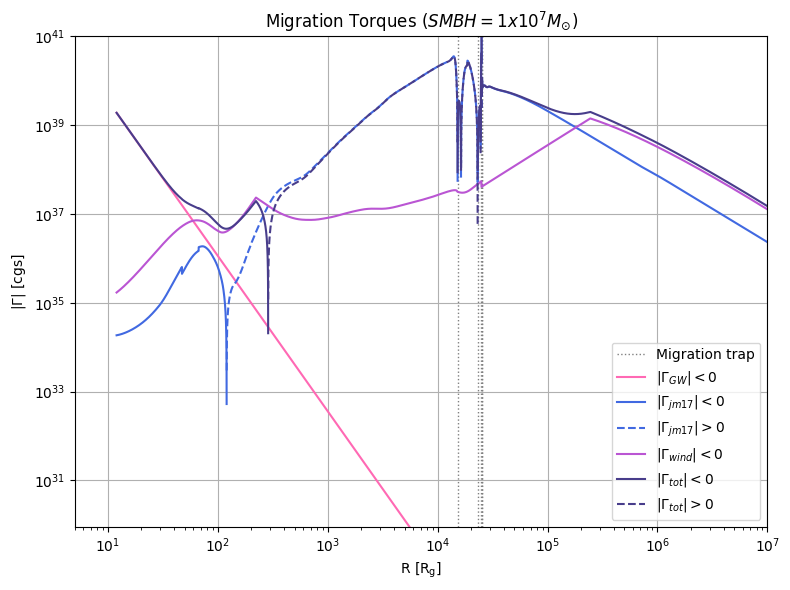

In [391]:
fig, ax = plt.subplots(figsize=(8, 6))

for trap in traps:
    ax.axvline(trap *2, color='gray', linestyle=':', linewidth=1, label='Migration trap' if trap == traps[0] else "")

# Mean line: solid for Gamma > 0, dashed for Gamma < 0
# Split into continuous regions of positive or negative torque

sign_changes2 = np.where(np.diff(np.sign(mean_Gamma_GW)) != 0)[0]
split_indices2 = np.concatenate(([0], sign_changes2 + 1, [len(Rs)]))

for i in range(len(split_indices2) - 1):
    start, end = split_indices2[i], split_indices2[i + 1]
    R_seg = Rs[start:end] *2
    G_seg = mean_Gamma_GW[start:end]
    if np.all(G_seg > 0):
        ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{GW}| >0$' if i == 1 else "", color='hotpink')
    elif np.all(G_seg < 0):
        ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{GW}| <0$' if i == 0 else "", color='hotpink')

sign_changes3 = np.where(np.diff(np.sign(mean_Gamma_jm17)) != 0)[0]
split_indices3 = np.concatenate(([0], sign_changes3 + 1, [len(Rs)]))

for i in range(len(split_indices3) - 1):
    start, end = split_indices3[i], split_indices3[i + 1]
    R_seg = Rs[start:end] *2
    G_seg = mean_Gamma_jm17[start:end]
    if np.all(G_seg > 0):
        ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{jm17}| >0$' if i == 1 else "", color='royalblue')
    elif np.all(G_seg < 0):
        ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{jm17}| <0$' if i == 0 else "", color='royalblue')

# sign_changes = np.where(np.diff(np.sign(mean_Gamma_b16)) != 0)[0]
# split_indices = np.concatenate(([0], sign_changes + 1, [len(Rs)]))

# for i in range(len(split_indices) - 1):
#     start, end = split_indices[i], split_indices[i + 1]
#     R_seg = Rs[start:end] *2
#     G_seg = mean_Gamma_b16[start:end]
#     if np.all(G_seg > 0):
#         ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{p10}| >0$' if i == 1 else "", color='darkslateblue')
#     elif np.all(G_seg < 0):
#         ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{p10}| <0$' if i == 0 else "", color='darkslateblue')

if winds==True:
    sign_changes4 = np.where(np.diff(np.sign(mean_Gamma_wind)) != 0)[0]
    split_indices4 = np.concatenate(([0], sign_changes4 + 1, [len(Rs)]))

    for i in range(len(split_indices4) - 1):
        start, end = split_indices4[i], split_indices4[i + 1]
        R_seg = Rs[start:end] *2
        G_seg = mean_Gamma_wind[start:end]
        if np.all(G_seg > 0):
            ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{wind}| >0$' if i == 1 else "", color='mediumorchid')
        elif np.all(G_seg < 0):
            ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{wind}| <0$' if i == 0 else "", color='mediumorchid')


sign_changes = np.where(np.diff(np.sign(mean_Gamma_tot)) != 0)[0]
split_indices = np.concatenate(([0], sign_changes + 1, [len(Rs)]))

for i in range(len(split_indices) - 1):
    start, end = split_indices[i], split_indices[i + 1]
    R_seg = Rs[start:end] *2
    G_seg = mean_Gamma_tot[start:end]
    if np.all(G_seg > 0):
        ax.plot(R_seg, np.abs(G_seg), 'k--', label='$|\Gamma_{tot}| >0$' if i == 1 else "", color='darkslateblue')
    elif np.all(G_seg < 0):
        ax.plot(R_seg, np.abs(G_seg), 'k-', label='$|\Gamma_{tot}| <0$' if i == 0 else "", color='darkslateblue')



ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'R [R$_{\rm g}$]')
ax.set_ylabel(r'$|\Gamma|$ [cgs]')
ax.set_ylim([9e29,1e41])
ax.set_xlim([0.5e1,1e7])
ax.set_title(f'Migration Torques ($SMBH = {MBH_digit}x10^{MBH_power}$'r'${M_{\odot}})$')

plt.legend()
plt.grid()
plt.tight_layout() 
# plt.savefig(f'Torques/{DT}/Wind/Migration_Torques_MBH{MBH_digit}e{MBH_power}_alpha{alpha}_damped.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
MBH_power=6
alpha=0.1
mdot=0.1
le=0.01
eps=0.1
spin=0.9

MBH=10**MBH_power * ct.MSun #in kgs

path=f'EMRIs_Jupiter_2/NT_profiles/logMBH{MBH_power}/alpha{alpha}/mdot{mdot}/spin{spin}/'

disk = Novikov.NovikovThorneAGN(Mbh=MBH, alpha=alpha)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk(path=path, save_to_file=False)
print(f'Disk.R: {disk.r}')


disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le= le, eps=eps)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk()

print(disk.R)

In [ ]:
MBH_powers= 4,5,6,7,8

spins=0.9, 0.99
alphas=0.1, 0.01

mdot = 0.1 #in terms of Ledd
eps = 0.1
le = mdot*eps

steps=int(1e4)

for power in MBH_powers:
    for alpha in alphas:
        for spin in spins:
            print(f'MBH=1e{power} MSun, alpha={alpha}, spin={spin}')
            path=f'EMRIs_Jupiter_2/NT_profiles/logMBH{power}/alpha{alpha}/mdot{mdot}/spin{spin}/'

            MBH=10**power*ct.MSun

            disk = Novikov.NovikovThorneAGN(Mbh=MBH, alpha=alpha, spin=spin)
            Rmin = disk.Rmin
            Rmax = disk.Rmax
            disk.solve_disk(steps=steps, path=path, save_to_file=False)
            print(f'Disk.R: {disk.R}')

In [ ]:
MBH=10**5 * ct.MSun
# spin=0.9
# Rmin=jscript.R_isco_function(MBH, spin)
# R_G=MBH * ct.G /(ct.c*ct.c)
# Rout=1e7*R_G
# sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)
# Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2

R_G=MBH * ct.G /(ct.c*ct.c)
Rout=1e7*R_G
sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)
Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2
diskTQM = pagn.ThompsonAGN(Mbh=MBH, Mdot_out=Mdot_out)

# diskTQM = pagn.ThompsonAGN(Mbh=MBH, Rin=Rmin, Rout=Rout, Mdot_out=Mdot_out)
diskTQM.solve_disk()


In [ ]:
Mdotmaxs=[]
Mdotouts=[]
MBHs=[]

powers=np.linspace(4,8, 1000)

flag=0

for power in powers:
    print(power)
    MBH=10**power * ct.MSun
    MBHs.append(MBH)

    R_G=MBH * ct.G /(ct.c*ct.c)

    Rout=1e7*R_G

    sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)

    Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2

    print(Mdot_out)

    diskTQM = edit.ThompsonAGN(Mbh=MBH, Rin=Rmin, Rout=Rout, Mdot_out=Mdot_out)
    diskTQM.solve_disk()
    Mdotmax= diskTQM.Mdotmax * (ct.yr / ct.MSun)
    Mdotout= diskTQM.Mdot_out * (ct.yr / ct.MSun)
    Mdotmaxs.append(Mdotmax)
    Mdotouts.append(Mdotout)
    if Mdotmax>Mdotout and flag==0:
        power_crit=power
        flag+=1

print(f'Mdot max exceeds Mdot out at SMBH = 1e{power_crit} MSun')

plt.plot(powers, Mdotmaxs, color='r', label='$\dot{M}_{max}$')
plt.plot(powers, Mdotouts, color='b', label='$\dot{M}_{out}$')
plt.axvline(x=power_crit)
plt.xlabel('$log(M_{SMBH})$')
plt.ylabel('$\dot{M}~[M_{\odot}yr^{-1}]$')
plt.title("")
plt.legend()
plt.show()
# diskTQM.solve_disk(N=1e4)

In [ ]:
colour='plasma'
cmap = plt.colormaps[colour]

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=100)

i=0
axs[i].plot(disk.R/R_G, 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(5, 1e6)
# axs[i].set_ylim(1, 1e7)
axs[i].set_ylim(1e-5, 1e6)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Surface Density vs Radius')

i=1
axs[i].plot(disk.R/R_G, disk.T*jscript.K_to_eV, color=cmap(0.0), label = r"SG")
axs[i].set_ylabel(r'$T [K] $')
axs[i].set_xlabel("r/Rg")

axs[i].set_xscale('log')
axs[i].set_yscale('log')

# axs[i].set_xlim(5, 1e7)
# axs[i].set_ylim(1e1, 3e7)
axs[i].set_ylim(1e-5, 1e6)
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Temperature vs Radius')

i=2

axs[i].plot(disk.R/R_G, disk.h/disk.R, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$h/r$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(1, 1e7)
# axs[i].set_ylim(1, 1e7)
axs[i].set_ylim(1e-5, 1e6)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Disc Thickness vs Radius')
axs[i].legend()

# i=3

# axs[i].plot(disk.R/R_G, disk.rho/1e3, label = r"SG", color=cmap(0.0))
# axs[i].set_ylabel(r'$\rho [?]$')
# axs[i].set_xlabel("r/Rg")

# # axs[i].set_xlim(1, 1e7)
# axs[i].set_ylim(1e-5, 1e5)
# axs[i].set_xscale('log')
# axs[i].set_yscale('log')
# axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

# axs[i].set_title(f'Midplane Surface Density vs Radius')
# axs[i].legend()

i=3

axs[i].plot(disk.R/R_G, disk.tauV, label = r"SG", color=cmap(0.0))
axs[i].set_ylabel(r'$\tau_V [?]$')
axs[i].set_xlabel("r/Rg")

# axs[i].set_xlim(1, 1e7)
axs[i].set_ylim(1e-5, 1e6)
axs[i].set_xscale('log')
axs[i].set_yscale('log')
axs[i].axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")

axs[i].set_title(f'Tau? vs Radius')
axs[i].legend()


plt.tight_layout()
plt.savefig(f'Pan+Yang/SG_profiles_logMBH{MBH_power}_alpha{alpha}_3.pdf')
plt.show()

In [ ]:
def BHL_accretion(args, obj, MBH, mbh, Mdot, gamma):
    drhodr=jscript.drhodR(obj)
    
    h=obj.h
    cs=obj.cs
    r=obj.R
    rho=obj.rho
    sigma= 2*h*rho

    E=MBH/(2*r)
    J=MBH * np.sqrt(1/(2*E))

    dJdr=jscript.dJdR(obj, J)

    deltav_psi=h*cs*(3-drhodr)/2
    deltav_dr=3/2 * (mbh/(3*MBH))**(1/3) * (1/h) * cs
    deltav_r=np.abs(-Mdot/(2 * np.pi * r * sigma) - gamma/dJdr)
    vrel=((deltav_psi + deltav_dr)**2 + deltav_r**2)**(1/2)
    mdot_BHL= (4 * np.pi * rho * mbh * mbh) / (vrel**2 + cs**2)**(3/2)
    return mdot_BHL

In [ ]:
Mbh=10**4 * ct.MSun
alpha=0.1
mdot=0.1
eps=0.1
mbh=10 * ct.MSun

le=eps*mdot

M=Mbh * ct.G /(ct.c*ct.c)

Ledd=jscript.Ledd(Mbh, X=0.7)
Mdot=le * Ledd / eps

disk = pagn.SirkoAGN(Mbh=Mbh, alpha=alpha, le=le, eps=eps)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk()

rho=disk.rho
cs=disk.cs
R=disk.R
h=disk.h
sigma=2*h*rho

gamma=jscript.drhodR(disk)

deltav_phi=(3-gamma)/2 * (h / R) * cs
deltav_dr=3/2 * (mbh/(3*Mbh))**(1/3) * (1/h) * cs

vgas=-Mdot/(2 * np.pi * R * sigma)
vstar=-1.3e-6 * (mbh/(10*ct.MSun))/(Mbh/(1e5*ct.MSun)) * (R/10*M)**(-3)
deltav_r=np.abs(vgas-vstar)

vrel_sqr=(deltav_phi + deltav_dr)**2 + deltav_r**2

mdot_BHL=(4 * np.pi * rho * mbh * mbh) / (vrel_sqr + cs**2)**(3/2)

print(mdot_BHL)

In [ ]:
from NT_disk_Eqns_V1 import A_fn, B_fn, C_fn, D_fn, E_fn, Q_fn

In [ ]:
def disc_solver(MBH_power, spin, alpha, mdot, eps, le, steps, path, printing=True, plotting=True, save_to_file=True):
    #general scaling from Abramowicz and Fragile
    MBH=10**MBH_power * ct.MSun #in kgs
    M=MBH * ct.G /(ct.c*ct.c)
    R_G=M

    m=MBH/ct.MSun
    Rsch= 2*ct.G*MBH/ct.c**2

    if mdot==None and le==None:
        raise ValueError('Please provide an accretion rate or Eddington ratio!')
    elif le==None:
        le=mdot*eps
    elif mdot==None:
        mdot=le/eps

    disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le=le, eps=eps)
    Rmin = disk.Rmin
    Rmax = disk.Rmax
    disk.solve_disk()

    print(f'SG: {Rmin/R_G} Rg, {disk.Rmin/R_G} Rg, {disk.R[0]/R_G} Rg')

    Rout=Rmax
    sigma = (200 * 1e3) * (MBH / (1.3e8*ct.MSun)) ** (1 / 4.24)
    Mdot_out = 320*(ct.MSun/ct.yr)*(Rout/(95*ct.pc)) * (sigma/(188e3))**2

    diskTQM = pagn.ThompsonAGN(Mbh=MBH, Rout=Rout, Rin=Rmin, Mdot_out=Mdot_out)
    diskTQM.solve_disk()

    print(f'TQM: {Rmin/R_G} Rg, {diskTQM.Rin/R_G} Rg, {diskTQM.R[0]/R_G} Rg')

    Rmin= jscript.R_isco_function(MBH, spin) #uses relativistic eqn for ISCO to set inner edge of disc
    r_isco=jscript.R_isco_function(MBH, spin)

    R=np.logspace(np.log10(r_isco), np.log10(Rmax), steps+1)
    # R=np.linspace(r_isco, Rmax, steps+1)

    R_im=jscript.R_inner_mid(r_isco, MBH, mdot, alpha)
    R_mo=jscript.R_mid_outer(r_isco, mdot)
    R_oa=jscript.R_outer_AGN(r_isco, MBH, mdot, alpha)

    R_agn=disk.R_AGN/R_G

    As=[]
    Bs=[]
    Cs=[]
    Ds=[]
    Es=[]
    Qs=[]

    coefficient=[]

    Rs=[]

    k=50
    if printing==True:
        print(R_oa/R_agn)
        print(f'Initial Radius = {R[k]/R_G} Rg, R_isco = {r_isco/R_G} Rg')

    for i in range(k, steps+1):
        r=R[i]
        y=np.sqrt(r/M)
        rstar=(r/M)
        r_im=jscript.r_in_mid(y, MBH, spin, mdot, alpha)
        r_mo=jscript.r_mid_outer(y, MBH, spin, mdot)

        A=A_fn(y, spin)
        B=B_fn(y, spin)
        C=C_fn(y, spin)
        D=D_fn(y, spin)
        E=E_fn(y, spin)
        Q=Q_fn(y, MBH, spin)

        coefficient.append(A**(2/3) * D**(-1/3) * Q**(2/3))

        As.append(A)
        Bs.append(B)
        Cs.append(C)
        Ds.append(D)
        Es.append(E)
        Qs.append(Q)

        Rs.append(rstar)
        
    plt.plot(Rs, As, label='A')
    # plt.plot(Rs, Bs, label='B')
    # plt.plot(Rs, Cs, label='C')
    plt.plot(Rs, Ds, label='D')
    # plt.plot(Rs, Es, label='E')
    plt.plot(Rs, Qs, label="Q")

    plt.plot(Rs, coefficient, label='coeff')

    plt.xlabel('R/M')

    plt.xscale('log')
    plt.yscale('log')

    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
mdot = 0.1 #in terms of Ledd
eps = 0.1
le = mdot*eps
# mdot=le/eps

disc_solver(4, 0.9, 0.1, mdot, eps, le, steps, path, printing=True, plotting=True, save_to_file=True)